In [57]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from utils import *

In [58]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    good_dict = {}

    for key in keys:

        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        timeLimit = mergedConfigs["sim-time-limit"]

        
        assert timeLimit.endswith('s'), "Time limit format is incorrect"
        timeLimit = timeLimit[:-1]  # Remove the 's' at the end

        if not measurement in good_dict:
            good_dict[measurement] = []

        good_dict[measurement].append({})
        good_dict[measurement][-1]['repetition']=int(repetition)
        good_dict[measurement][-1]['timeLimit']=int(timeLimit)
        good_dict[measurement][-1]['modules']={}

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in good_dict[measurement][-1]['modules']:
                good_dict[measurement][-1]['modules'][module] = {}

            good_dict[measurement][-1]['modules'][module][name] = {}
            good_dict[measurement][-1]['modules'][module][name]["times"] = a["time"]
            good_dict[measurement][-1]['modules'][module][name]["values"] = a["value"]



    return good_dict


good_dict = importData("../multicore_sched/simulations/test.json")

In [59]:
#print keys of good_dict one under another
for key in good_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=12, $generationType="uniform", $durationType="uniform", $isFCFS=false
$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=300ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=false
$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.9, $meanProc

In [60]:

# filter={
#     "$pCpuBound"                : None,
#     "$meanGenerationTime"       : '30ms',
#     "$rho"                      : None,
#     "$numCpus"                  : None,
#     "$generationType"           : '"exponential"',
#     "$durationType"             : '"exponential"',
#     "$isFCFS"                   : 'false'
# }

# filter={
#     "$pCpuBound"                : '0.1',
#     "$meanGenerationTime"       : '30ms',
#     "$rho"                      : '0.7',
#     "$numCpus"                  : '4',
#     "$generationType"           : '"exponential"',
#     "$durationType"             : '"exponential"',
#     "$isFCFS"                   : 'true'
# }

filter={
    "$pCpuBound"                : None,
    "$rho"                      : None,
    "$meanProcessDuration"       : '300ms',
    "$numCpus"                  : None,
    "$generationType"           : '"exponential"',
    "$durationType"             : '"exponential"',
    "$isFCFS"                   : 'true'
}

In [61]:
filtered_dict={}
filtered_array=[]

for key, value in good_dict.items():
    key_dict = dict(item.split("=") for item in key.split(", "))
    match = True
    for f_key, f_value in filter.items():
        if f_value is None:
            continue
        if key_dict.get(f_key) != f_value:
            break
    else:
        filtered_dict[key] = value
        filtered_array.append(value)

print(filtered_dict.keys())

dict_keys(['$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true', '$pCpuBound=0.1, $rho=0.4, $meanProcessDuration=300ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true', '$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true', '$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=300ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true', '$pCpuBound=0.9, $rho=0.4, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true', '$pCpuBound=0.9, $rho=0.4, $meanProcessDuration=300ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true', '$pCpuBound=0.9, $rho=0.9, $meanProcessDuration=300ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS

In [62]:
statistic='turnaroundTime:vector'
testToUse=list(filtered_dict.keys())[0]

In [63]:
values = filtered_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

In [64]:
def getMeasurement(axs,measurement):
    x=0
    y=0
    if "$numCpus=12" in measurement:
        x+=1
    if "$pCpuBound=0.9" in measurement:
        y=1

    # Format measurent = "$pCpuBound=0.1, $meanGenerationTime=30ms, $rho=0.4, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false"
    # to pCpuBound=0.1, numCpus=4
    parts = measurement.split(", ")

    pCpuBound = next(part for part in parts if "pCpuBound" in part)[1:]
    numCpus = next(part for part in parts if "numCpus" in part)[1:]

    measurementString = f"{pCpuBound}, {numCpus}"
    
    rhoNum = next(part for part in parts if "rho" in part).split("=")[1]

    rhoString = f"ρ = {rhoNum}"

    
    return axs[x][y],measurementString,rhoString

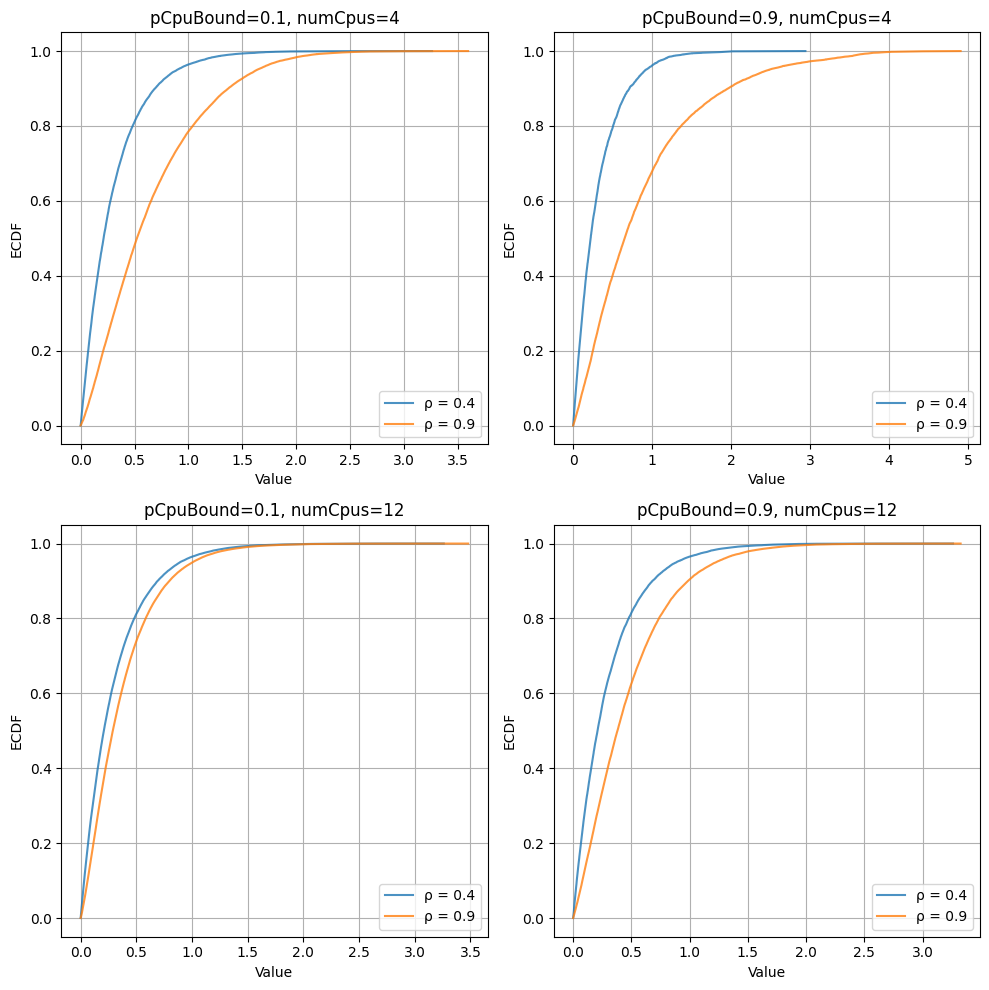

In [68]:
from statsmodels.distributions.empirical_distribution import ECDF

#for each element in filtered_array plt ecdf of statistic
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array):
    measurement = list(filtered_dict.keys())[i]
    values = element[0]['modules']["Computer.scheduler"][statistic]["values"]
    ecdf = ECDF(values)
    ax,measurementString,rhoString = getMeasurement(axs, measurement)
    ax.plot(ecdf.x, ecdf.y, label=rhoString,alpha=0.8)
    # ax.set_title(f"ECDF of {measurement}")
    ax.set_xlabel('Value')
    ax.set_ylabel('ECDF')
    ax.set_title(measurementString)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

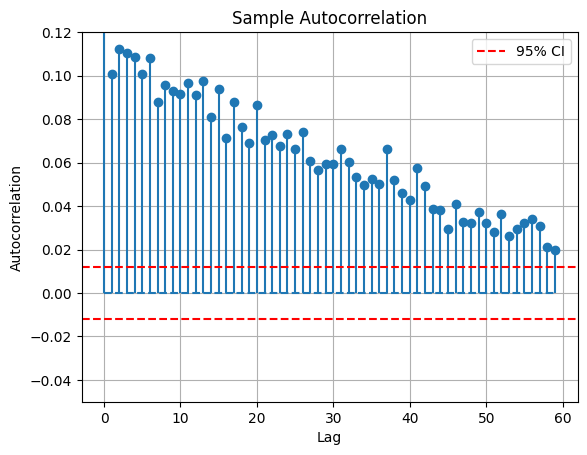

h: 30, Q: 5871.930530969884
Outside interval: 860, 3.1702731595827034%
Outside interval: 82, 82.82828282828282%
Now the number of samples is: 27128


In [158]:

p=1/2**0

new_values=[]

for value in values:
    rand=np.random.uniform()
    if rand<p:
        new_values.append(value)

values=new_values


avg, std = avg_and_std(values)

# Calculate autocorrelation
autocorr_values = autocorrelation(values)

stop=60
lags=range(0,stop)

plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
plt.title(f"Sample Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
plt.ylim(top=0.12)


# Add horizontal lines at ±1.96/sqrt(n)
n = len(values)  # Sample size
confidence_interval = 1.96 / np.sqrt(n)
plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
plt.axhline(y=-confidence_interval, color='r', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()


#Ljung–Box test

h=30

Q=0
n=len(values)

for i in range(1,h):
    Q+=n*(n+2)*(autocorr_values[i]**2)/(n-i)

print(f"h: {h}, Q: {Q}")

# Calculate number of values outside confidence interval

outside=0


test_values=autocorr_values[1:]

for value in test_values:
    if value > confidence_interval or value < -confidence_interval:
        outside+=1

print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# Calculate number of values outside confidence interval near

outside=0
stop=100

test_values=autocorr_values[1:stop]

for value in test_values:
    if value > confidence_interval or value < -confidence_interval:
        outside+=1

print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

print(f"Now the number of samples is: {len(values)}")

In [159]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def statsModelIndependence(values):
    result = acorr_ljungbox(values, lags=30)
    Qs=result.iloc[:,0]
    pvalues=result.iloc[:,1]
    return Qs,pvalues

def testIndependence(values,sigLevel=0.05):
    Qs,pvalues=statsModelIndependence(values)
    return all(pvalues>sigLevel)
# testIndependence(values)


def makeValuesIndependent(values):
    k=0
    j=0

    testvalues=values.copy()

    while not testIndependence(testvalues):

        j+=1

        if j==3:
            k+=1
            j=0
        p=1/2**k

        random.seed(j)

        testvalues=[]

        for value in values:
            rand=random.random()
            if rand<p:
                testvalues.append(value)
        
    print(f"At the end k={k}, number of samples is: {len(testvalues)}")

    return testvalues


At the end k=5, number of samples is: 883


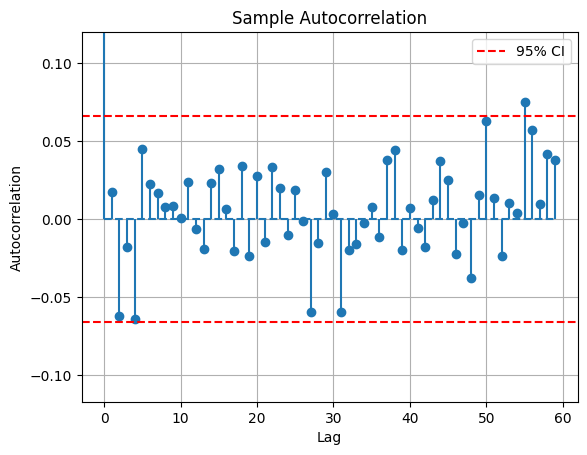

In [160]:
# testToUse=names[1]

values = filtered_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

values= makeValuesIndependent(values)

avg, std = avg_and_std(values)

# Calculate autocorrelation
autocorr_values = autocorrelation(values)

stop=60
lags=range(0,stop)

plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
plt.title(f"Sample Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
plt.ylim(top=0.12)


# Add horizontal lines at ±1.96/sqrt(n)
n = len(values)  # Sample size
confidence_interval = 1.96 / np.sqrt(n)
plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
plt.axhline(y=-confidence_interval, color='r', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()


Fitted with mean 0.37825094762850053


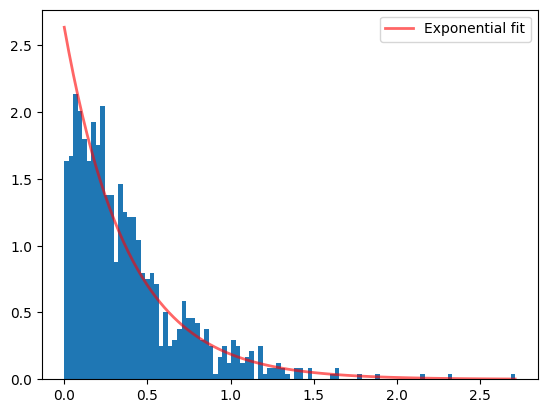

In [161]:
from scipy.stats import expon

#histogram of values
bins=100
plt.hist(values,bins=bins,density=True)

#plot also a exponential curve
# Fit an exponential distribution to the data
loc, scale = expon.fit(values,floc=0)
print(f"Fitted with mean {scale}")

# Generate the x values for the exponential curve
x = np.linspace(min(values), max(values), bins)

# Plot the exponential curve
# plt.plot(x, 2*len(values)/bins*expon.pdf(x, loc, scale), 'r-', lw=2, label='Exponential fit', alpha=0.8)
plt.plot(x, expon.pdf(x, 0, scale), 'r-', lw=2, label='Exponential fit', alpha=0.6)
plt.legend()
# plt.xlim(-0.05,1.5)
plt.show()


In [162]:
#qq plot
import scipy.stats as stats

# Generate a QQ plot
# fig, ax = plt.subplots()
res=stats.probplot(values, dist="expon", sparams=(loc, scale))

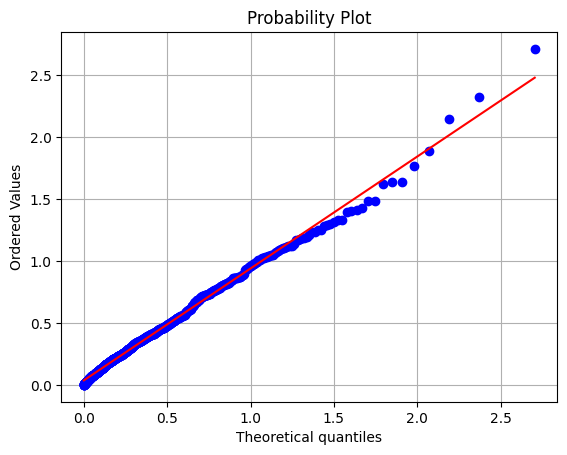

In [163]:
#plot 1 quantile for each 10 available

step=1
# step=len(values)//20

# Generate a QQ plot with step
fig, ax = plt.subplots()
res = stats.probplot(values[::step], dist="expon", sparams=(loc, scale), plot=ax)
ax.grid(True)
plt.show()

In [164]:
from scipy.stats import bootstrap

In [165]:
def stdDev(values):
    return np.std(values)
def mean(values):
    return np.mean(values)

Confidence interval for mean: 0.3561958752531683 to 0.4037970617275141
Confidence interval for mean: 0.3151897254908216 to 0.37660792229987355


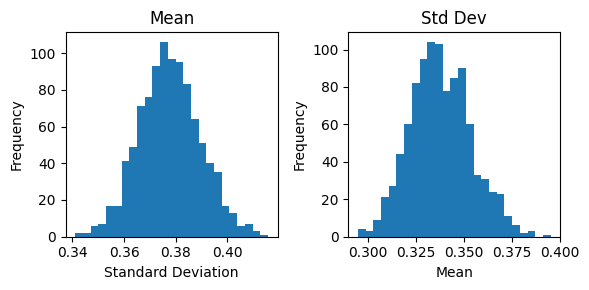

In [172]:
data = (values,)  # samples must be in a sequence

# Bootstrap for mean
res_mean = bootstrap(data, mean, n_resamples=999, confidence_level=0.95)
low, high = res_mean.confidence_interval
print(f"Confidence interval for mean: {low} to {high}")
bins=25
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].hist(res_mean.bootstrap_distribution, bins=bins)
ax[0].set_title('Mean')
ax[0].set_xlabel('Standard Deviation')
ax[0].set_ylabel('Frequency')

# Bootstrap for std dev
res_dev = bootstrap(data, stdDev, n_resamples=999, confidence_level=0.95)
low, high = res_dev.confidence_interval
print(f"Confidence interval for mean: {low} to {high}")

ax[1].hist(res_dev.bootstrap_distribution, bins=bins)
ax[1].set_title('Std Dev')
ax[1].set_xlabel('Mean')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



In [167]:
sampMean, sampStd = avg_and_std(values)

confLef=sampMean-1.96*sampStd/np.sqrt(len(values))
confRig=sampMean+1.96*sampStd/np.sqrt(len(values))

print(f"Confidence interval: {confLef} to {confRig}")

Confidence interval: 0.3558933801515206 to 0.40060851510548046


In [154]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

nsample = 100

rng = np.random.default_rng()